In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

# Lecture 11: Recap

## 4/29/18

### Table Of Contents
1. [EDA, Data Loading/Processing](#section1)  
2. [Feature Engineering](#section2)  
3. [Modeling](#section3) <br>
    3.1 [Loss Functions](#section3.1) <br>
    3.2 [Linear Regression](#section3.2) <br>
    3.3 [KNN, Decision Trees, Random Forest](#section3.3) <br>
    3.4 [Neural Networks](#section3.4) <br>

### Hosted by and maintained by the [Statistics Undergraduate Students Association (SUSA)](http://susa.berkeley.edu) (Authored by Ajay Raj)

The classic problem in data science, as we've learned, is given a $n$ by $d$ **design matrix** $X$ ($n$ rows of training points with $d$ features), and a response variable $y$, represented by a $n$ by $1$ column vector, find a function $h(x)$, which takes in a $d$ by $1$ point and outputs a prediction $\hat{y}$.

<a id='section1'></a>
## EDA, Data Loading/Processing

We first learned how to store a **design matrix** in Python using **Pandas**. As an example today, we'll be using the Iris dataset, where the features are attributes of a flower and the response variable is **categorical**, and represents which type of iris flower the features are describing.

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_target = pd.Series(iris['target'])
iris_df['iris'] = iris_target
iris_df['iris'].replace([0, 1, 2], iris['target_names'], inplace=True)

In [3]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),iris
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The first step in solving the problem is **understanding the design matrix**, called **exploratory data analysis (EDA)**. Using matplotlib and seaborn, we learned how to make plots like the one shown below:

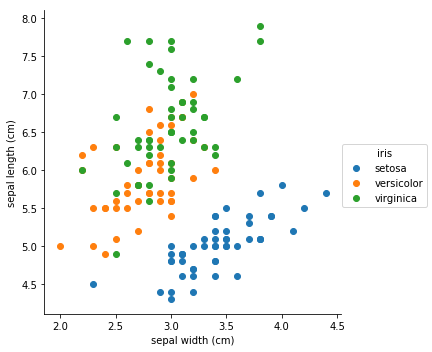

In [4]:
sns.FacetGrid(iris_df, hue="iris", size=5) \
   .map(plt.scatter, "sepal width (cm)", "sepal length (cm)") \
   .add_legend()
plt.show()

<a id='section2'></a>
## Feature Engineering

The next step of accomplishing the task is deciding the features for the model, or creating new features that are good predictors for the response variable.

In [5]:
iris_df['sepal_area'] = iris_df['sepal length (cm)'] * iris_df['sepal width (cm)']

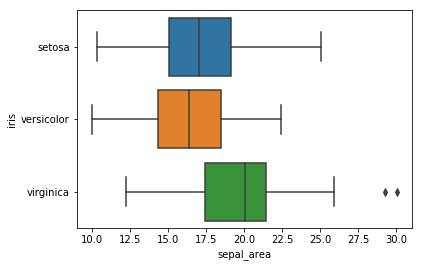

In [6]:
sns.boxplot(x="sepal_area", y="iris", data=iris_df);

Given a dataset with **many** features (like the one in your project), when deciding the number of features for the model, consider the **bias-variance tradeoff**:

<img src='img/biasvariance.png'/>

As the number of features in your model increases, you do reduce your error with respect to your loss function, but the variance of the model (i.e. given small changes in the training set, how much the model changes) increases as well. Finding the right balance between **bias** and **variance** is probably the *most* important question when creating your model.

The "sepal area" feature doesn't seem very good when we see the boxplots, so let's drop it.

In [7]:
iris_df.drop(['sepal_area'], axis = 1, inplace = True)

**NOTE**: Feature engineering is usually THE MOST important step of the data science process. Really good features with a simple linear regression model will beat bad features passed into a complex model like a neural network.

<a id='section3'></a>
## Modeling

<a id='section3.1'></a>
### Loss Functions

Before you choose which model to use, you must first choose how to evaluate the models that you create (sort of like before completing an assignment, you should look at the rubric). A **loss function** $L(\hat{y}, y)$ either takes in a vector of predictions or one, and returns a number, high if the prediction is incorrect, and low if not. Losses are usually positive.

When the response variable $y$ is continuous (i.e. it is **numerical**, not **categorical**), this is called **regression**. The most common loss function for regression is called **mean squared error**. For a vector of predictions $\hat{y}_1, ..., \hat{y}_n$, and the vector of actual values $y_1, ..., y_n$:

$$\text{MSE}(\hat{y}, y) = \frac{1}{n} \sum_{i = 1}^n (\hat{y}_i - y_i)^2$$

When $y$ is categorical (it takes on discrete values that have no numerical meaning), this is called **classification**. You can use MSE for classification, but it doesn't work as well because it penalizes errors between different classes over others when it doesn't make sense. Instead, a common loss function for **classification** is called **categorical cross entropy**:

$$\text{CrossEntropy}(\hat{y}, y) = -\sum_{i = 1}^n \sum_{\text{class } k} y_{ik} \log {\hat {y}}_{ik}$$

<a id='section3.2'></a>
### Linear Regression

Now that you've created and cleaned your **design matrix**, the next steps is to choose your model for the response variable $y$. The simplest regression model is called **linear regression**, where the goal is to find a vector $w$ of weights, such that $\hat{y} = w^T x$. Linear regression uses **mean squared error**, and has a closed form solution if the features are not collinear:

$$\hat{w} = (X^T X)^{-1} X^T y$$

For our example today, let's regress **petal length** on the rest of the features (instead of predicting the iris species, which is a classification task. Note: linear regression can be used for this using rounding, but I'd rather not give away the answer to the project).

In [8]:
X, y = iris_df[['sepal length (cm)', 'sepal width (cm)', 'petal width (cm)']], iris_df['petal length (cm)']

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)
model.score(X, y) # training accuracy of the model

0.968150119089107

#### Regularization in Linear Regression

We also talked about methods to reduce a linear regression model's **variance** using a **regularization** term in the loss. You can also do this technique with any other loss like categorical cross-entropy.

$$\text{MSE-Ridge}(\hat{y}, y, w) = \frac{1}{n} \sum_{i = 1}^n (\hat{y}_i - y_i)^2 + \lambda \sum_{i = 1}^d w_i^2$$
$$\text{MSE-LASSO}(\hat{y}, y, w) = \frac{1}{n} \sum_{i = 1}^n (\hat{y}_i - y_i)^2 + \lambda \sum_{i = 1}^d |w_i|$$

#### Validation, Evaluation

When we examine training accuracy, however, we have no idea about overfitting: training accuracy is a measure of the model's **bias**, but not its **variance**. So, a common practice in data science is to partition around 20% of your data not to be trained on as your validation set. To set up the discussion of decision trees and neural networks, we take iris species as our response variable and the rest of the columns as our design matrix.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(iris_df.iloc[:, :-1], iris_df['iris'], test_size = 0.2)

<a id='section3.3'></a>
### KNN, Decision Trees, Random Forest

We'll now go through a few different ways to solve classification tasks using nonlinear methods (note that each of these tasks can be used for regression as well, but we'll focus on classification today).

#### KNN

The first example of nonlinear methods that we discussed is **$k$-nearest-neighbor (KNN)**. Basically, it just means: of the $k$ closest training points to $x$, choose the majority class.

The hyperparameter $k$ trades off bias and variance, as $k$ decreases, variance increases (at $k = 1$, if one training point changes, the model changes).

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn_1_model = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(knn_1_model.predict(X_valid), y_valid)

0.9666666666666667

In [31]:
knn_50_model = KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train)

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(knn_50_model.predict(X_valid), y_valid)

0.8

#### Decision Trees

The problem with many complex models is that they do not provide **inference**: i.e. once you have a model, it is pretty much a black box: you don't know the process that the model goes through to predict a training point from the weights (you sort of can, but it's tough for sure).

Decision trees provide a step-by-step decision process for a model to classify a point.

The pseudocode of a decision tree is as follows:

1. Choose a feature
2. Find a place in the sorted list of feature values to split
3. Create two subsets of the data, one for each side of the split
4. Repeat 1-3 again

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
dt_model = DecisionTreeClassifier().fit(X_train, y_train)

In [36]:
accuracy_score(dt_model.predict(X_valid), y_valid)

0.9333333333333333

One of the most important hyperparameters for decision trees is called **max depth**: i.e. how many decisions should be made in predicting a point? This parameter also trades off with bias-variance, as **max-depth** increases, **variance** increases because a slight change can affect an overall prediction more.

In [45]:
dt_model = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)

In [46]:
accuracy_score(dt_model.predict(X_valid), y_valid)

0.6666666666666666

#### Random Forest

Finally, we talked a little about **ensemble learning**, where the idea is that *the wisdom of the many trumps the wisdom of the few*. If we train many classifiers and take their average, or majority, we will most likely come up with a better prediction than any one classifier.

Ensemble learning is a method of dealing with the **variance** of a classifier: the idea for why is that the variance of the sample mean decreases as $n$ increases. For example, if $X_i \sim \mathcal{N}(\mu, \sigma^2)$, $\overline{X} \sim \mathcal{N}(\mu, \frac{\sigma^2}{n})$.

Furthermore, for ensemble learning to work, each of the classifiers is **supposed** to overfit on the training set in some way, because then the average will capture more features of the training set. 

A **random forest** is a set of **decision trees** that ensemble together. We ensure that we get interesting decision trees by introducing **randomness** in two ways:

1. Bootstrapping the data, or sampling the training points with replacement
2. At each split in the decision trees, limiting the number of features to split on by taking a random subset

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_train, y_train)

In [49]:
accuracy_score(rf_model.predict(X_valid), y_valid)

0.9333333333333333

It turns out that one decision tree is enough to capture the data.

<a id='section3.4'></a>
### Neural Networks

This was the last nonlinear method that we discussed. **Neural networks** are nothing more than linear regression models, but the features are learned by introducing **nonlinear function composition** of the input features.

In [52]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [96]:
model = Sequential()

In [97]:
model.add(Dense(4, activation='relu', input_shape=(4,)))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
y_train_oe = pd.get_dummies(y_train)
y_valid_oe = pd.get_dummies(y_valid)

In [99]:
model.fit(x=X_train.values, y=y_train_oe.values, epochs=20, batch_size=1);

Epoch 1/20
120/120 [==============================] - 0s - loss: 4.3062 - acc: 0.3417       
Epoch 2/20
120/120 [==============================] - 0s - loss: 2.0340 - acc: 0.3417     
Epoch 3/20
120/120 [==============================] - 0s - loss: 1.3316 - acc: 0.3417      
Epoch 4/20
120/120 [==============================] - 0s - loss: 1.0443 - acc: 0.3667     
Epoch 5/20
120/120 [==============================] - 0s - loss: 0.8728 - acc: 0.5417      
Epoch 6/20
120/120 [==============================] - 0s - loss: 0.7870 - acc: 0.7667     
Epoch 7/20
120/120 [==============================] - 0s - loss: 0.7171 - acc: 0.8250     
Epoch 8/20
120/120 [==============================] - 0s - loss: 0.6544 - acc: 0.8250     
Epoch 9/20
120/120 [==============================] - 0s - loss: 0.5977 - acc: 0.8250     
Epoch 10/20
120/120 [==============================] - 0s - loss: 0.5502 - acc: 0.8500      
Epoch 11/20
120/120 [==============================] - 0s - loss: 0.5120 - acc: 0.88

In [100]:
valid_preds = pd.Series(np.argmax(model.predict(X_valid.values), axis=1)).replace([0, 1, 2], iris['target_names'])

In [101]:
train_preds = pd.Series(np.argmax(model.predict(X_train.values), axis=1)).replace([0, 1, 2], iris['target_names'])

In [102]:
accuracy_score(train_preds, y_train)

0.9583333333333334

In [103]:
accuracy_score(valid_preds, y_valid)

0.9333333333333333

As you can see, **the neural network wasn't better than a simple decision tree** with two levels! This is what we want you to get out of the last few weeks: big and complex models are interesting and exciting, but are NOT always the correct option for your data. The model that you choose depends on the data you are given. For example, in this case, we only had 150 points and a few features: simple models tend to do better on this, and they trained faster. Never lose sight of the EDA and feature engineering steps of the process: they are the MOST important when you're given a data science problem in the real world, and they inform you on what model to choose.

It is easy to get bogged down in complex models like XGBoost and feedforward neural networks, but in the end, favor **Occam's razor**, which says that "simpler solutions are more likely to be correct than complex ones". Not only are simpler models easier to debug, they are easier to make conclusions from, and are less likely to overfit.

# Project worktime!